## Network Diagnostics

In [114]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# excetions show up normally
%xmode plain

# plots show up inline
%matplotlib inline

def get_device(no_gpu=False):
    """
    Returns one of cuda / mps / cpu based on availablity
    """
    if no_gpu is True:
        return torch.device("cpu")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# Choose the default device
no_gpu = True
default_device = get_device(no_gpu)


# Needed to import modules from src
import sys
sys.path.append('..')


# Get Project Root (needed for reading config)
import os
projectRoot = os.path.dirname(os.getcwd())
print(projectRoot)


from src.loadData import loadData
import src.utils as utils

all_data = loadData(projectRoot)
vocab = utils.get_vocab(all_data)
print(f"Vocab Length:{len(vocab)}")

encode, decode = utils.get_encode_decode(vocab)
print(f"Encode test: {encode("emma")}\tDecode test: {decode(encode("emma"))}")
# print(f"Encode test: {encode("e")}\tDecode test: {decode(encode("e"))}")

train_percentage = 0.8
train_boundary = math.ceil(len(all_data) * train_percentage)

cv_percentage = train_percentage + 0.1
cv_boundary = math.ceil(len(all_data) * cv_percentage)

train_data = all_data[:train_boundary]
cv_data = all_data[train_boundary:cv_boundary]
test_data = all_data[cv_boundary:]

print(f"Name Counts ==> All:{len(all_data)}\tTrain:{len(train_data)}\t Validation:{len(cv_data)}\tTest: {len(test_data)} ")


import src.utils as utils

context_length = 3

xtr, ytr = utils.get_samples(train_data, encode, context_size=context_length)
Xtr, Ytr = torch.tensor(xtr, device=default_device), torch.tensor(ytr, device=default_device)

xcv, ycv = utils.get_samples(cv_data, encode, context_size=context_length)
Xcv, Ycv = torch.tensor(xcv, device=default_device), torch.tensor(ycv, device=default_device)

xtest, ytest = utils.get_samples(test_data, encode, context_size=context_length)
Xtest, Ytest = torch.tensor(xtest, device=default_device), torch.tensor(ytest, device=default_device)

print(f"Sample Sizes ==> Training:{Xtr.shape[0]}\tValidation:{Xcv.shape[0]}\tTest:{Xtest.shape[0]}")

Exception reporting mode: Plain
e:\Karpathy-Makemore
Vocab Length:27
Encode test: [5, 13, 13, 1]	Decode test: emma
Name Counts ==> All:32033	Train:25627	 Validation:3203	Test: 3203 
Sample Sizes ==> Training:182784	Validation:22632	Test:22730


#### Creating a Model 

In [122]:
import src.Model as M

# Hyper Parameters
g = torch.Generator(device=default_device).manual_seed(2147483627)
feature_dim = 30
n_hidden = 200
learning_rate = 0.1
minibatch_size = 100

default_gain = 5/3
add_batch_norm = True

lossi_tr = []
lossi_cv = []
update_to_data_ratio = []

vocab_len = len(vocab)
input_dim = context_length * feature_dim
model = M.Sequential(

        M.Embedding(vocab_len, feature_dim, d=default_device),
        M.Flatten(input_dim),

        M.Linear(input_dim, n_hidden, d=default_device, bias=False, gain=default_gain, scale_factor=-1.0),
        M.BatchNorm1d(n_hidden, d=default_device) if add_batch_norm is True else M.NoOp(),
        M.Tanh(),

        M.Linear(n_hidden, n_hidden, d=default_device, bias=False, gain=default_gain, scale_factor=-1.0),
        M.BatchNorm1d(n_hidden, d=default_device) if add_batch_norm is True else M.NoOp(),
        M.Tanh(),

        M.Linear(n_hidden, n_hidden, d=default_device, bias=False, gain=default_gain, scale_factor=-1.0),
        M.BatchNorm1d(n_hidden, d=default_device) if add_batch_norm is True else M.NoOp(),
        M.Tanh(),
        
        M.Linear(n_hidden, n_hidden, d=default_device, bias=False, gain=default_gain, scale_factor=-1.0),
        M.BatchNorm1d(n_hidden, d=default_device) if add_batch_norm is True else M.NoOp(),
        M.Tanh(),

        M.Linear(n_hidden, n_hidden, d=default_device, bias=False, gain=default_gain, scale_factor=-1.0),
        M.BatchNorm1d(n_hidden, d=default_device) if add_batch_norm is True else M.NoOp(),
        M.Tanh(),

        M.Linear(n_hidden, n_hidden, d=default_device, bias=False, gain=default_gain, scale_factor=-1.0),
        M.BatchNorm1d(n_hidden, d=default_device) if add_batch_norm is True else M.NoOp(),
        M.Tanh(),

        M.Linear(n_hidden, vocab_len, d=default_device, gain=1.0, bias=False, scale_factor=0.01)
)

for p in model.parameters():
        p.requires_grad = True

#### Training Loop

Epoch:0 Training Loss: 3.3043351125717164	 Validation Loss:3.300941438674927
Epoch:1000 Training Loss: 2.192406964302063	 Validation Loss:2.4426843118667603
Epoch:2000 Training Loss: 2.117178336381912	 Validation Loss:2.414297378063202
Epoch:3000 Training Loss: 2.115929443836212	 Validation Loss:2.363187415599823
Epoch:4000 Training Loss: 2.1072836196422577	 Validation Loss:2.3618008494377136
Epoch:5000 Training Loss: 2.062293576002121	 Validation Loss:2.3569096660614015
Epoch:6000 Training Loss: 2.0519079983234407	 Validation Loss:2.349481601715088
Epoch:7000 Training Loss: 2.0727271676063537	 Validation Loss:2.3518936824798584
Epoch:8000 Training Loss: 2.0394590771198273	 Validation Loss:2.3518563258647918
Epoch:9000 Training Loss: 2.0276032984256744	 Validation Loss:2.328872971534729


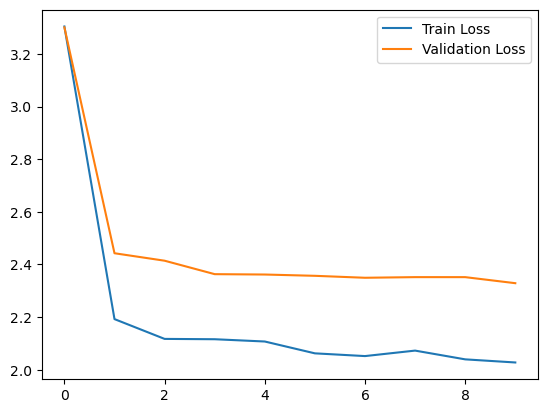

In [123]:
epochs = 10000
learning_rate = 0.1

for epoch in range(epochs):

    # Minibatch
    ix = torch.randint(Xtr.shape[0], size=(minibatch_size,), device=default_device, generator=g)
    X, Y = Xtr[ix], Ytr[ix]

    # Forward Pass
    model.train()
    logits = model(X)

    # Loss 
    loss = F.cross_entropy(logits, Y)

    # Retain Grad for debug
    for i,l in enumerate(model.layers):
        l.out.retain_grad()

    if epoch % 1000 == 0:
        model.eval()
        lossi_tr.append(M.estimateError(Xtr, Ytr, model))
        lossi_cv.append(M.estimateError(Xcv, Ycv, model))
        print(f"Epoch:{epoch} Training Loss: {lossi_tr[-1]}\t Validation Loss:{lossi_cv[-1]}")
        model.train()

    # Zero Grad
    for p in model.parameters():
        p.grad = None

    # Backward Pass
    loss.backward()

    with torch.no_grad():
         update_to_data_ratio.append([((learning_rate*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])
    
    # Update Weight
    for p in model.parameters():
        p.data -= learning_rate * p.grad


plt.plot(lossi_tr, label="Train Loss")
plt.plot(lossi_cv, label="Validation Loss")
plt.legend(loc="upper right")
plt.show()

#### Tanh Activation Distribution across the layers

Layer:   4 | Tanh | Mean: -0.0002 	| std: 0.6236 | Saturation :4.70%
Layer:   7 | Tanh | Mean: 0.0011 	| std: 0.6355 | Saturation :4.79%
Layer:  10 | Tanh | Mean: -0.0028 	| std: 0.6489 | Saturation :4.20%
Layer:  13 | Tanh | Mean: -0.0003 	| std: 0.6566 | Saturation :3.86%
Layer:  16 | Tanh | Mean: -0.0010 	| std: 0.6685 | Saturation :3.32%
Layer:  19 | Tanh | Mean: 0.0012 	| std: 0.6781 | Saturation :2.12%


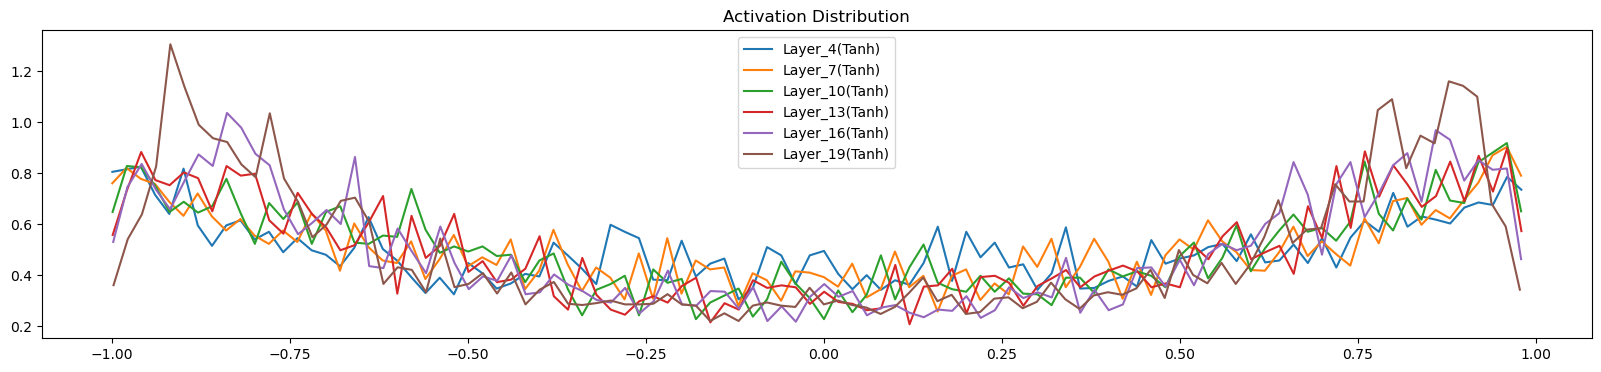

In [124]:
plt.figure(figsize=(20,4))
legends = []

for i, l in enumerate(model.layers[:-1]):
    if isinstance(l, M.Tanh) is False:
        continue

    t = l.out
    print(f"Layer:{i:4d} | {l.__class__.__name__} | Mean: {t.mean():.4f} \t| std: {t.std():.4f} | Saturation :{(t.abs() > 0.97).float().mean()*100:.2f}%")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"Layer_{i}({l.__class__.__name__})")

plt.legend(legends)
plt.title("Activation Distribution")
plt.show()

#### Tanh Gradient Distribution

Layer:   4 | Tanh | Mean: -0.000000000001 	| std: 0.000936341065
Layer:   7 | Tanh | Mean: 0.000000000003 	| std: 0.000836513587
Layer:  10 | Tanh | Mean: 0.000000000000 	| std: 0.000800053356
Layer:  13 | Tanh | Mean: 0.000000000003 	| std: 0.000782177318
Layer:  16 | Tanh | Mean: -0.000000000000 	| std: 0.000774572603
Layer:  19 | Tanh | Mean: 0.000010383269 	| std: 0.000791641825


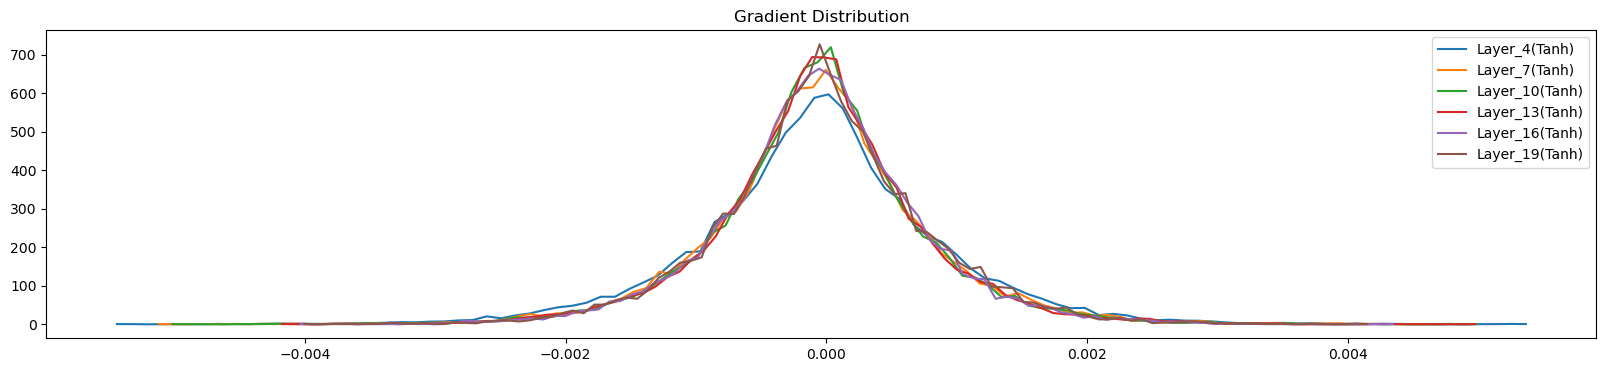

In [128]:
plt.figure(figsize=(20,4))
legends = []

for i, l in enumerate(model.layers[:-1]):
    if isinstance(l, M.Tanh) is False:
        continue

    t = l.out.grad
    print(f"Layer:{i:4d} | {l.__class__.__name__} | Mean: {t.mean():.12f} \t| std: {t.std():.12f}")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"Layer_{i}({l.__class__.__name__})")

plt.legend(legends)
plt.title("Gradient Distribution")
plt.show()

#### Weights Distribution

Shape:(27, 30) |  Mean: 0.000000000028 | std: 0.0043 | grad to data ratio: 0.00439412659034133
Shape:(90, 200) |  Mean: 0.000002189356 | std: 0.0042 | grad to data ratio: 0.02342219091951847
Shape:(200, 200) |  Mean: -0.000039430201 | std: 0.0031 | grad to data ratio: 0.025485925376415253
Shape:(200, 200) |  Mean: 0.000015221807 | std: 0.0029 | grad to data ratio: 0.023542288690805435
Shape:(200, 200) |  Mean: -0.000004595993 | std: 0.0028 | grad to data ratio: 0.023429961875081062
Shape:(200, 200) |  Mean: 0.000047678473 | std: 0.0027 | grad to data ratio: 0.022081227973103523
Shape:(200, 200) |  Mean: -0.000007682411 | std: 0.0024 | grad to data ratio: 0.020097073167562485
Shape:(200, 27) |  Mean: 0.000000000003 | std: 0.0110 | grad to data ratio: 0.11969242990016937


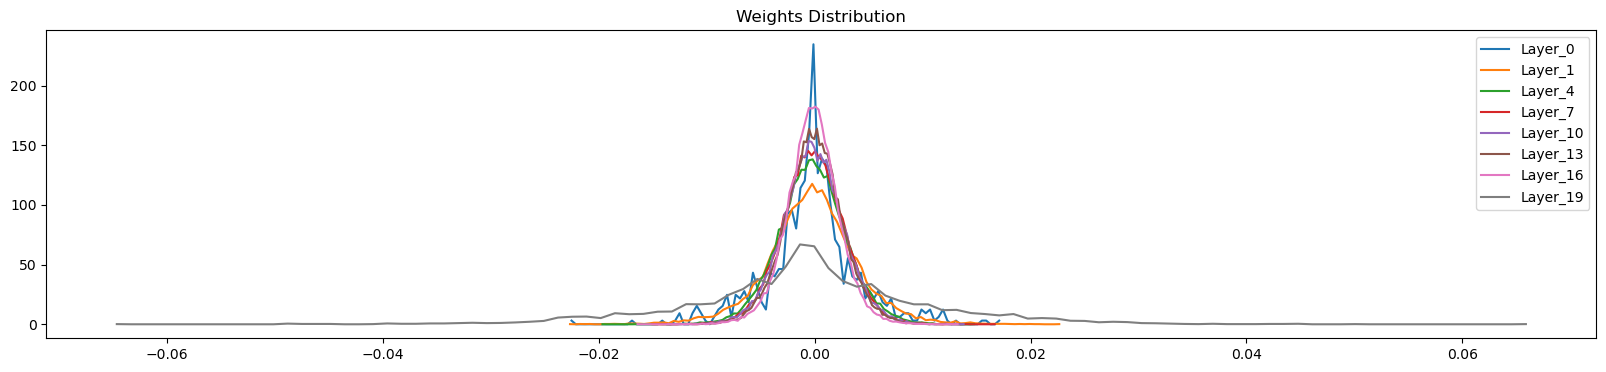

In [126]:
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(model.parameters()):
    t = p.grad
    if p.ndim != 2:
        continue

    print(f"Shape:{tuple(p.shape)} |  Mean: {t.mean():.12f} | std: {t.std():.4f} | grad to data ratio: {t.std()/p.std()}")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"Layer_{i}")

plt.legend(legends)
plt.title("Weights Distribution")
plt.show()

#### Parameter Data vs Parameter update Ratio

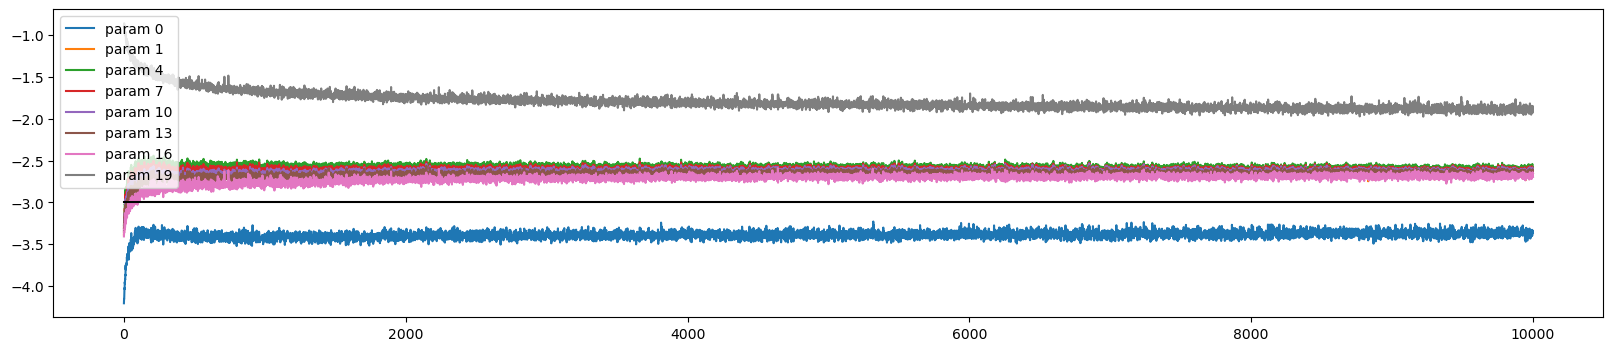

In [127]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
    legends.append('param %d' % i)
plt.plot([0, len(update_to_data_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.show()